## Using Keras to Build and Train Neural Networks

This exercise is based on Intel's course at: https://software.intel.com/content/dam/develop/public/us/en/downloads/intel-dl101-class5.zip and at: https://software.intel.com/content/www/us/en/develop/training/course-deep-learning.html. 

We will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## UCI Pima Diabetes Dataset

* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [ ]:
#Dina Pinchuck 
#Preliminaries

from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

%matplotlib inline

In [ ]:
## Import Keras objects for Deep Learning

from keras.models  import Sequential
#from keras import backend as K
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

In [ ]:
## Load in the data set (Internet Access needed)
url = 'https://github.com/rosenfa/nn/blob/master/pima-indians-diabetes.csv?raw=true'
diabetes_df=pd.read_csv(url,  header=0, error_bad_lines=False)

In [ ]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
464,10,115,98,0,0,24.0,1.022,34,0
228,4,197,70,39,744,36.7,2.329,31,0
74,1,79,75,30,0,32.0,0.396,22,0
634,10,92,62,0,0,25.9,0.167,31,0
224,1,100,66,15,56,23.6,0.666,26,0


In [ ]:
X = np.asarray(diabetes_df.drop('Outcome',1))
y = np.asarray(diabetes_df['Outcome'])

In [ ]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

In [ ]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [ ]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.750
roc-auc is 0.821


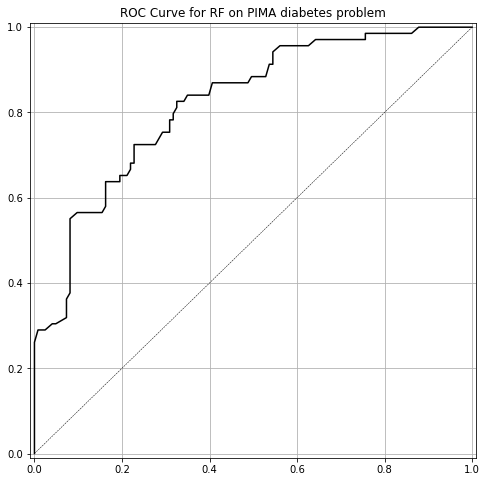

In [ ]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])


plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 12 nodes.

In [ ]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications


normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

Keras has many shapes.  See: https://keras.io/api/layers/core_layers/dense/ for information about "dense" and sequential means a "basic" ordering (as opposed to more complicated ones we'll learn about starting next week).

In [ ]:
# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

model_1 = Sequential([
    Dense(12, input_shape=(8,), activation="relu"),
    Dense(1, activation="sigmoid")
])

In [ ]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 12)                108       
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 13        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


### Comprehension question:
Why do we have 121 parameters?  Does that make sense?
Think about why there are 108 parameters in first layer when only 8 features exist and the network has 12 nodes (8*12 is NOT 108), and why the output layer has 13 values for only 12 nodes.


Let's fit our model for 200 epochs.

In [ ]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(SGD(lr = .003, momentum=0.8), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=50)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Epoch 1/50
18/18 [==============================] - 0s 10ms/step - loss: 0.6842 - accuracy: 0.5721 - val_loss: 0.6892 - val_accuracy: 0.5260
Epoch 2/50
18/18 [==============================] - 0s 3ms/step - loss: 0.6755 - accuracy: 0.5962 - val_loss: 0.6715 - val_accuracy: 0.5573
Epoch 3/50
18/18 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6413 - val_loss: 0.6569 - val_accuracy: 0.5833
Epoch 4/50
18/18 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6513 - val_loss: 0.6442 - val_accuracy: 0.6146
Epoch 5/50
18/18 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6573 - val_loss: 0.6326 - val_accuracy: 0.6458
Epoch 6/50
18/18 [==============================] - 0s 3ms/step - loss: 0.6144 - accuracy: 0.6693 - val_loss: 0.6219 - val_accuracy: 0.6458
Epoch 7/50
18/18 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6633 - val_loss: 0.6128 - val_accuracy: 0.6562
Epoch 8/50
18/18 [=

In [ ]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_class_nn_1 = model_1.predict_classes(X_test_norm)
y_pred_prob_nn_1 = model_1.predict(X_test_norm)

In [ ]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

array([[1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0]], dtype=int32)

In [ ]:
y_pred_prob_nn_1[:10]

array([[0.5044797 ],
       [0.5977279 ],
       [0.38748872],
       [0.43398145],
       [0.17274612],
       [0.60273755],
       [0.05143183],
       [0.28233328],
       [0.85006946],
       [0.16597658]], dtype=float32)

accuracy is 0.740
roc-auc is 0.798


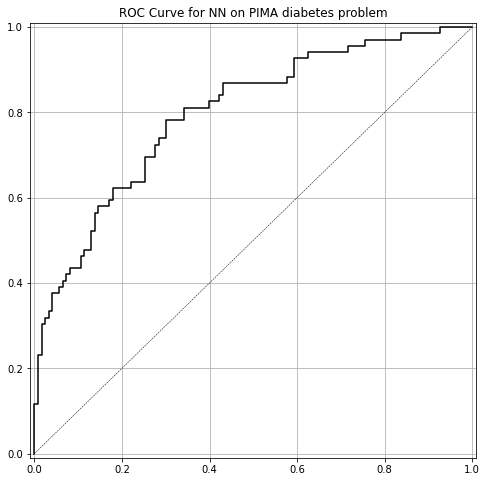

In [ ]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results similar to the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [ ]:
run_hist_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

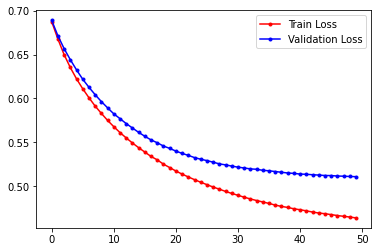

In [ ]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 450 more epochs.

In [ ]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=450)

Epoch 1/450
18/18 [==============================] - 0s 5ms/step - loss: 0.4630 - accuracy: 0.7674 - val_loss: 0.5107 - val_accuracy: 0.7448
Epoch 2/450
18/18 [==============================] - 0s 3ms/step - loss: 0.4623 - accuracy: 0.7674 - val_loss: 0.5106 - val_accuracy: 0.7448
Epoch 3/450
18/18 [==============================] - 0s 3ms/step - loss: 0.4616 - accuracy: 0.7691 - val_loss: 0.5104 - val_accuracy: 0.7448
Epoch 4/450
18/18 [==============================] - 0s 3ms/step - loss: 0.4607 - accuracy: 0.7691 - val_loss: 0.5104 - val_accuracy: 0.7500
Epoch 5/450
18/18 [==============================] - 0s 3ms/step - loss: 0.4600 - accuracy: 0.7708 - val_loss: 0.5104 - val_accuracy: 0.7500
Epoch 6/450
18/18 [==============================] - 0s 3ms/step - loss: 0.4595 - accuracy: 0.7726 - val_loss: 0.5100 - val_accuracy: 0.7552
Epoch 7/450
18/18 [==============================] - 0s 3ms/step - loss: 0.4586 - accuracy: 0.7708 - val_loss: 0.5101 - val_accuracy: 0.7552
Epoch 8/450
1

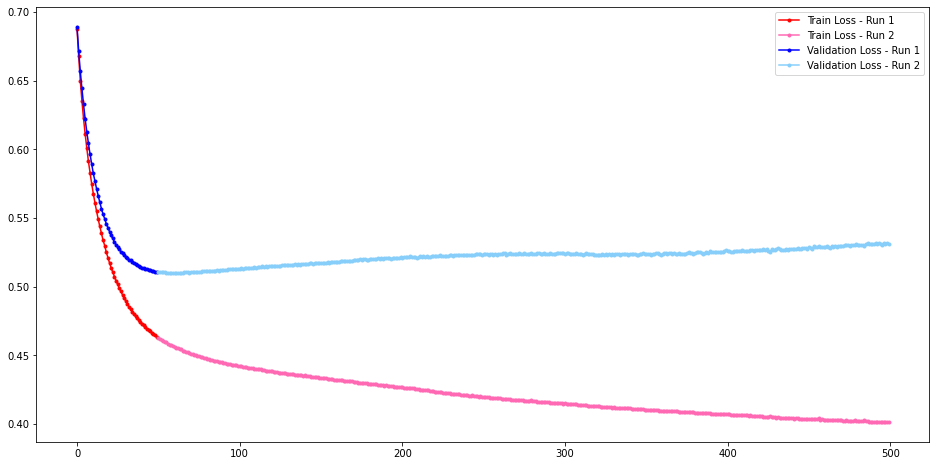

In [ ]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?

accuracy is 0.740
roc-auc is 0.808


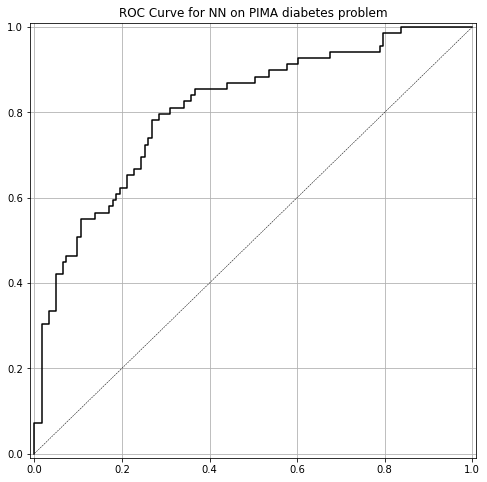

In [ ]:
y_pred_class_nn_1 = model_1.predict_classes(X_test_norm)
y_pred_prob_nn_1 = model_1.predict(X_test_norm)
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

## Exercise
Now it's your turn.  Do the following in the cells below:
- Build a model, model_2, with two hidden layers, each with 6 nodes
- Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer
- Use a learning rate of .003 and train for 100 epochs
- Graph the trajectory of the loss functions, accuracy on both train and test set
- Plot the roc curve for the predictions

You might want to look at the Keras documentation at: 
https://keras.io/guides/sequential_model/

Experiment with one network with 3 layers and save it as model_3. Did it work better?
Did using more or less epochs help?
Trying different learning rates for model_3.  Did that work better?

(Accuracys are based off the last time I ran each model, the accuracy can change since random is used in the code)
Experiment with one network with 3 layers and save it as model_3. Did it work better? Model_3 worked better than model_2 


Did using more or less epochs help? Using more epochs resulted in a slightly worse accuracy and using less resulted in a slight better accuracy.
Trying different learning rates for model_3.  Did that work better? using a higher learning rate resulted in a slightly worse accuracy and using a lower learning resulted in a lower accuracy. 

In [ ]:
# Type your code here for model_2 with layers 1,2 having activation relu and layer 3 with activation sigmoid
# Define the Model 
# Input size is 8-dimensional

model_2 = Sequential([
    Dense(6, input_shape=(8,), activation="relu"),
    Dense(6, activation="relu"),
    Dense(1, activation="sigmoid")
])
model_2.compile(SGD(lr = .003, momentum=0.8), "binary_crossentropy", metrics=["accuracy"])
run_hist_2 = model_2.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=100)

Epoch 1/100
18/18 [==============================] - 0s 10ms/step - loss: 0.7336 - accuracy: 0.5023 - val_loss: 0.6734 - val_accuracy: 0.5990
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 0.7149 - accuracy: 0.5519 - val_loss: 0.6599 - val_accuracy: 0.6458
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6836 - accuracy: 0.6016 - val_loss: 0.6481 - val_accuracy: 0.6562
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6671 - accuracy: 0.6495 - val_loss: 0.6382 - val_accuracy: 0.6719
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.6108 - val_loss: 0.6293 - val_accuracy: 0.7083
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6647 - accuracy: 0.6384 - val_loss: 0.6210 - val_accuracy: 0.7188
Epoch 7/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6446 - val_loss: 0.6137 - val_accuracy: 0.7188
Epoch 8/100


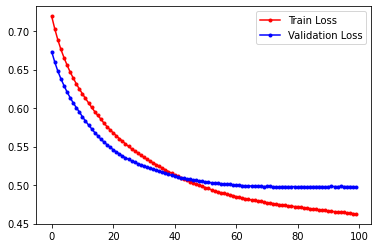

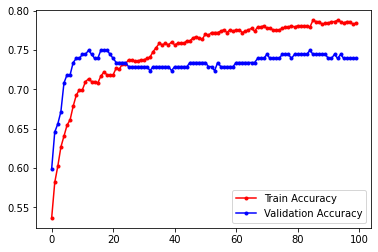

In [ ]:
# Graph the trajectory of the loss functions, accuracy on both train and test set for model_2
#Loss
fig, ax = plt.subplots()
ax.plot(run_hist_2.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_2.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()
#Accuracy
fig, ax = plt.subplots()
ax.plot(run_hist_2.history["accuracy"],'r', marker='.', label="Train Accuracy")
ax.plot(run_hist_2.history["val_accuracy"],'b', marker='.', label="Validation Accuracy")
ax.legend()

accuracy is 0.740
roc-auc is 0.813


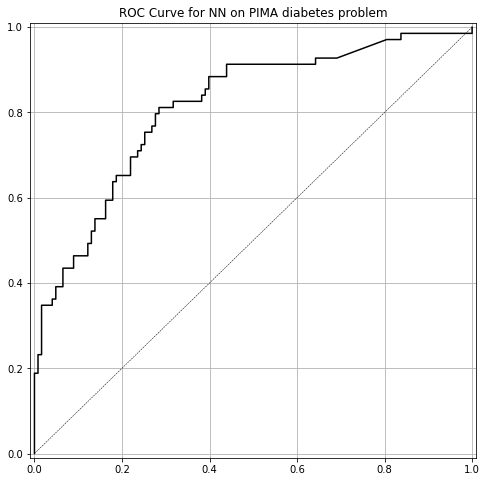

In [ ]:
# Type your code here to plot the loss accuracy and ROC curve for model_2
y_pred_class_nn_2 = model_2.predict_classes(X_test_norm)
y_pred_prob_nn_2 = model_2.predict(X_test_norm)
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_2)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_2)))

plot_roc(y_test, y_pred_prob_nn_2, 'NN')

Epoch 1/100
18/18 [==============================] - 0s 10ms/step - loss: 0.7753 - accuracy: 0.3528 - val_loss: 0.7100 - val_accuracy: 0.4635
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 0.7262 - accuracy: 0.4319 - val_loss: 0.6808 - val_accuracy: 0.5208
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5518 - val_loss: 0.6646 - val_accuracy: 0.6406
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.6542 - val_loss: 0.6534 - val_accuracy: 0.6979
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6598 - accuracy: 0.7184 - val_loss: 0.6455 - val_accuracy: 0.7240
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6661 - accuracy: 0.6468 - val_loss: 0.6398 - val_accuracy: 0.7083
Epoch 7/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6576 - accuracy: 0.6293 - val_loss: 0.6349 - val_accuracy: 0.7083
Epoch 8/100


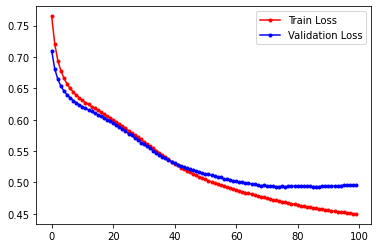

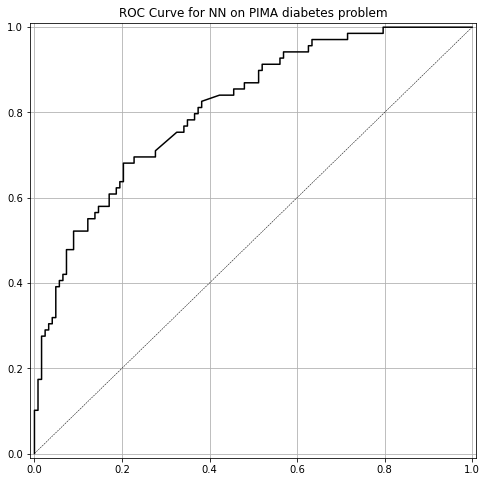

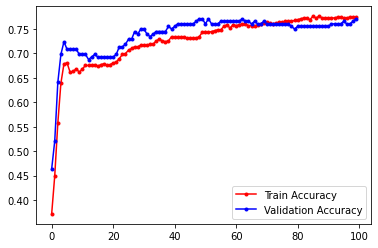

In [ ]:
# Type your code here for model_3 with layers 1,2,3 having activation relu and layer 4 with activation sigmoid
# Define the Model 

model_3 = Sequential([
    Dense(4, input_shape=(8,), activation="relu"),
    Dense(6, activation="relu"),
    Dense(7, activation="relu"),
    Dense(1, activation="sigmoid")
])
model_3.compile(SGD(lr = .003, momentum=0.8), "binary_crossentropy", metrics=["accuracy"])
run_hist_3 = model_3.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=100)
# Type your code here to plot the loss accuracy and ROC curve for model_3
#Loss
fig, ax = plt.subplots()
ax.plot(run_hist_3.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_3.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

#Roc
y_pred_class_nn_3 = model_3.predict_classes(X_test_norm)
y_pred_prob_nn_3 = model_3.predict(X_test_norm)
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_3)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_3)))
plot_roc(y_test, y_pred_prob_nn_3, 'NN')

#Accuracy
fig, ax = plt.subplots()
ax.plot(run_hist_3.history["accuracy"],'r', marker='.', label="Train Accuracy")
ax.plot(run_hist_3.history["val_accuracy"],'b', marker='.', label="Validation Accuracy")
ax.legend()

Epoch 1/250
18/18 [==============================] - 1s 10ms/step - loss: 0.8648 - accuracy: 0.6127 - val_loss: 0.7931 - val_accuracy: 0.6406
Epoch 2/250
18/18 [==============================] - 0s 3ms/step - loss: 0.7652 - accuracy: 0.6631 - val_loss: 0.7351 - val_accuracy: 0.6406
Epoch 3/250
18/18 [==============================] - 0s 3ms/step - loss: 0.7155 - accuracy: 0.6607 - val_loss: 0.7091 - val_accuracy: 0.6406
Epoch 4/250
18/18 [==============================] - 0s 3ms/step - loss: 0.6976 - accuracy: 0.6557 - val_loss: 0.6927 - val_accuracy: 0.6406
Epoch 5/250
18/18 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.6620 - val_loss: 0.6822 - val_accuracy: 0.6406
Epoch 6/250
18/18 [==============================] - 0s 3ms/step - loss: 0.6721 - accuracy: 0.6695 - val_loss: 0.6745 - val_accuracy: 0.6406
Epoch 7/250
18/18 [==============================] - 0s 3ms/step - loss: 0.6687 - accuracy: 0.6597 - val_loss: 0.6679 - val_accuracy: 0.6406
Epoch 8/250


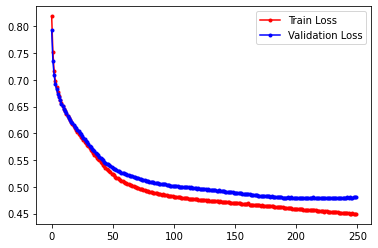

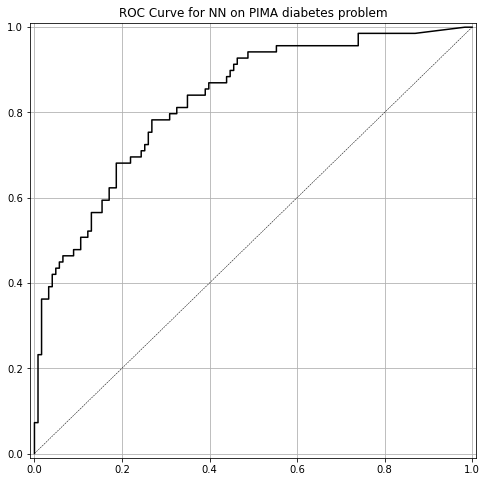

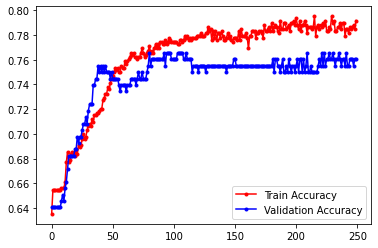

In [ ]:
# Try using more or less epochs and different learning rates for model_3 

#more epochs
model_3_1 = Sequential([
    Dense(4, input_shape=(8,), activation="relu"),
    Dense(6, activation="relu"),
    Dense(7, activation="relu"),
    Dense(1, activation="sigmoid")  
])
model_3_1.compile(SGD(lr = .003, momentum=0.8), "binary_crossentropy", metrics=["accuracy"])
run_hist_3_1 = model_3_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=250)

#Loss
fig, ax = plt.subplots()
ax.plot(run_hist_3_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_3_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

#Roc
y_pred_class_nn_3_1 = model_3_1.predict_classes(X_test_norm)
y_pred_prob_nn_3_1 = model_3_1.predict(X_test_norm)
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_3_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_3_1)))
plot_roc(y_test, y_pred_prob_nn_3_1, 'NN')

#Accuracy
fig, ax = plt.subplots()
ax.plot(run_hist_3_1.history["accuracy"],'r', marker='.', label="Train Accuracy")
ax.plot(run_hist_3_1.history["val_accuracy"],'b', marker='.', label="Validation Accuracy")
ax.legend()



Epoch 1/50
18/18 [==============================] - 1s 10ms/step - loss: 0.6851 - accuracy: 0.6603 - val_loss: 0.6631 - val_accuracy: 0.7240
Epoch 2/50
18/18 [==============================] - 0s 3ms/step - loss: 0.6646 - accuracy: 0.7224 - val_loss: 0.6475 - val_accuracy: 0.7344
Epoch 3/50
18/18 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.7334 - val_loss: 0.6348 - val_accuracy: 0.7240
Epoch 4/50
18/18 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6965 - val_loss: 0.6246 - val_accuracy: 0.7188
Epoch 5/50
18/18 [==============================] - 0s 3ms/step - loss: 0.6283 - accuracy: 0.7009 - val_loss: 0.6152 - val_accuracy: 0.7240
Epoch 6/50
18/18 [==============================] - 0s 3ms/step - loss: 0.6191 - accuracy: 0.6959 - val_loss: 0.6070 - val_accuracy: 0.7240
Epoch 7/50
18/18 [==============================] - 0s 3ms/step - loss: 0.6055 - accuracy: 0.7108 - val_loss: 0.5995 - val_accuracy: 0.7292
Epoch 8/50
18/18 [=

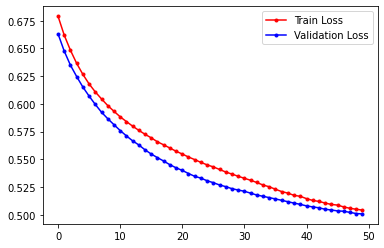

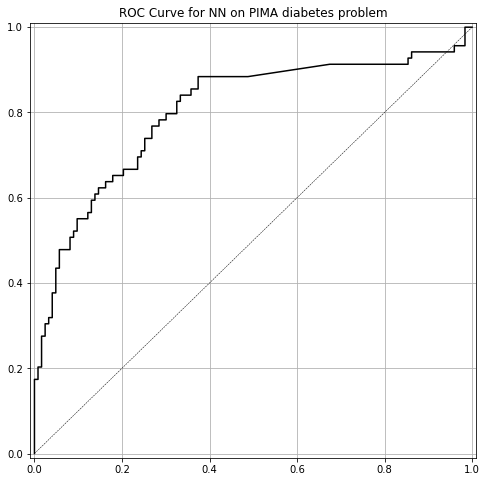

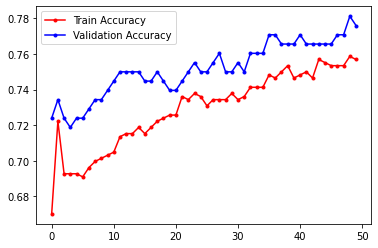

In [ ]:
#less epochs
model_3_2 = Sequential([
    Dense(4, input_shape=(8,), activation="relu"),
    Dense(6, activation="relu"),
    Dense(7, activation="relu"),
    Dense(1, activation="sigmoid")
])
model_3_2.compile(SGD(lr = .003, momentum=0.8), "binary_crossentropy", metrics=["accuracy"])
run_hist_3_2 = model_3_2.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=50)

#Loss
fig, ax = plt.subplots()
ax.plot(run_hist_3_2.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_3_2.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

#Roc
y_pred_class_nn_3_2 = model_3_2.predict_classes(X_test_norm)
y_pred_prob_nn_3_2 = model_3_2.predict(X_test_norm)
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_3_2)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_3_2)))
plot_roc(y_test, y_pred_prob_nn_3_2, 'NN')

#Accuracy
fig, ax = plt.subplots()
ax.plot(run_hist_3_2.history["accuracy"],'r', marker='.', label="Train Accuracy")
ax.plot(run_hist_3_2.history["val_accuracy"],'b', marker='.', label="Validation Accuracy")
ax.legend()

Epoch 1/100
18/18 [==============================] - 1s 11ms/step - loss: 0.5834 - accuracy: 0.6622 - val_loss: 0.5516 - val_accuracy: 0.6719
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 0.5030 - accuracy: 0.7282 - val_loss: 0.5596 - val_accuracy: 0.7448
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 0.5101 - accuracy: 0.7475 - val_loss: 0.5318 - val_accuracy: 0.7292
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 0.4734 - accuracy: 0.7591 - val_loss: 0.5646 - val_accuracy: 0.7448
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 0.4843 - accuracy: 0.7764 - val_loss: 0.6198 - val_accuracy: 0.6562
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 0.5035 - accuracy: 0.7612 - val_loss: 0.5179 - val_accuracy: 0.7344
Epoch 7/100
18/18 [==============================] - 0s 3ms/step - loss: 0.4400 - accuracy: 0.8126 - val_loss: 0.5788 - val_accuracy: 0.6615
Epoch 8/100


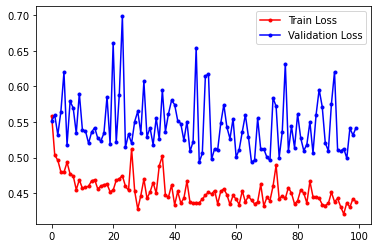

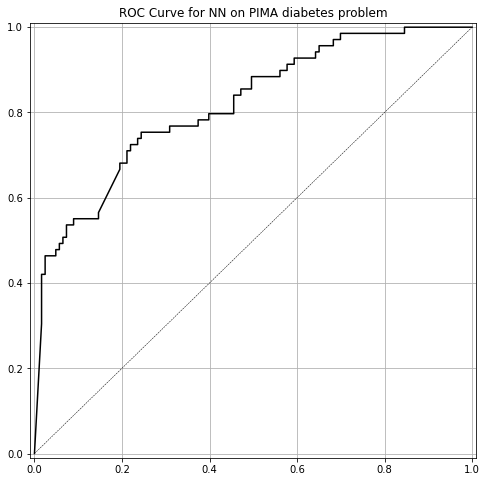

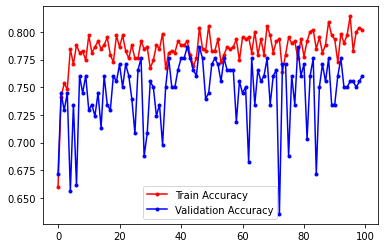

In [ ]:
#different learning rate - 0.3
model_3_3 = Sequential([
    Dense(4, input_shape=(8,), activation="relu"),
    Dense(6, activation="relu"),
    Dense(7, activation="relu"),
    Dense(1, activation="sigmoid")
])
model_3_3.compile(SGD(lr = .3, momentum=0.8), "binary_crossentropy", metrics=["accuracy"])
run_hist_3_3 = model_3_3.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=100)

#Loss
fig, ax = plt.subplots()
ax.plot(run_hist_3_3.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_3_3.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

#Roc
y_pred_class_nn_3_3 = model_3_3.predict_classes(X_test_norm)
y_pred_prob_nn_3_3 = model_3_3.predict(X_test_norm)
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_3_3)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_3_3)))
plot_roc(y_test, y_pred_prob_nn_3_3, 'NN')

#Accuracy
fig, ax = plt.subplots()
ax.plot(run_hist_3_3.history["accuracy"],'r', marker='.', label="Train Accuracy")
ax.plot(run_hist_3_3.history["val_accuracy"],'b', marker='.', label="Validation Accuracy")
ax.legend()

Epoch 1/100
18/18 [==============================] - 1s 11ms/step - loss: 0.7177 - accuracy: 0.3869 - val_loss: 0.7124 - val_accuracy: 0.4115
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 0.7050 - accuracy: 0.4400 - val_loss: 0.6992 - val_accuracy: 0.4688
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6980 - accuracy: 0.5273 - val_loss: 0.6893 - val_accuracy: 0.5312
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5915 - val_loss: 0.6822 - val_accuracy: 0.5885
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6774 - accuracy: 0.6294 - val_loss: 0.6765 - val_accuracy: 0.6250
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.6563 - val_loss: 0.6720 - val_accuracy: 0.6354
Epoch 7/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6670 - accuracy: 0.6676 - val_loss: 0.6684 - val_accuracy: 0.6562
Epoch 8/100


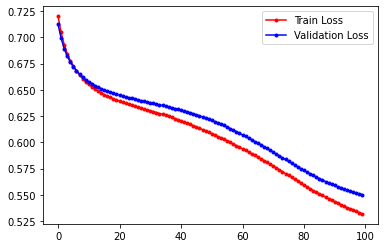

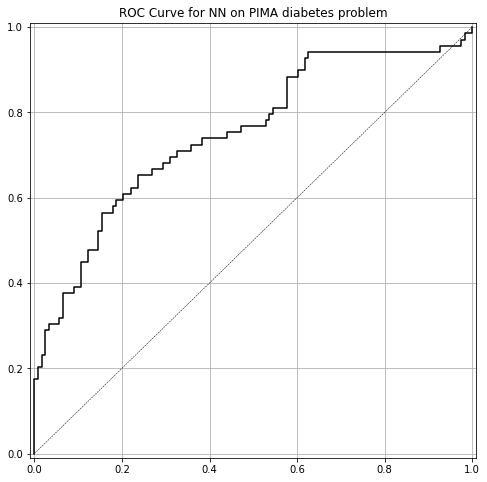

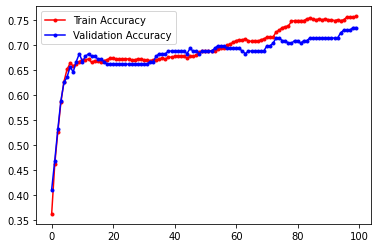

In [ ]:
#different learning rate - 0.002

model_3_4 = Sequential([
    Dense(4, input_shape=(8,), activation="relu"),
    Dense(6, activation="relu"),
    Dense(7, activation="relu"),
    Dense(1, activation="sigmoid")
])
model_3_4.compile(SGD(lr = .002, momentum=0.8), "binary_crossentropy", metrics=["accuracy"])
run_hist_3_4 = model_3_4.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=100)

#Loss
fig, ax = plt.subplots()
ax.plot(run_hist_3_4.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_3_4.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

#Roc
y_pred_class_nn_3_4 = model_3_4.predict_classes(X_test_norm)
y_pred_prob_nn_3_4 = model_3_4.predict(X_test_norm)
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_3_4)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_3_4)))
plot_roc(y_test, y_pred_prob_nn_3_4, 'NN')

#Accuracy
fig, ax = plt.subplots()
ax.plot(run_hist_3_4.history["accuracy"],'r', marker='.', label="Train Accuracy")
ax.plot(run_hist_3_4.history["val_accuracy"],'b', marker='.', label="Validation Accuracy")
ax.legend()